In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    #('count', lambda x: x.sample(frac = 1).head(5).shape[0])

    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0])]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True, tuning_ratio = 0.1):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == tuning_ratio)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
test_path = './results/eval_ilt.txt'
df_grouped = prep_and_store_results(test_path)

['ILT', '0.5', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.0000005', '4']
Lengths {13}
Number of evaluations: 2352
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,35.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
1,ILT,image_to_text_R@1,45.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
2,ILT,image_to_text_R@5,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
3,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
4,ILT,text_to_image_R@1,65.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2347,ILT,image_to_text_R@5,90.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2348,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2349,ILT,text_to_image_R@1,35.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2350,ILT,text_to_image_R@5,80.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,35.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
1,ILT,image_to_text_R@1,45.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
2,ILT,image_to_text_R@5,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
3,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
4,ILT,text_to_image_R@1,65.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2347,ILT,image_to_text_R@5,90.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2348,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2349,ILT,text_to_image_R@1,35.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2350,ILT,text_to_image_R@5,80.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16


value  \
                                                                                                   mean   
PL   method ProbVLM metric            epochs dataset lr           bs AL.iter AL.epochs ratio              
None base   False   image_to_text_R@1 5      ILT     5.000000e-07 4  NaN     NaN       0.5    41.666667   
                                                                  8  NaN     NaN       0.5    46.666667   
                                                                  16 NaN     NaN       0.5    63.125000   
                                                     5.000000e-06 4  NaN     NaN       0.5    52.000000   
                                                                  8  NaN     NaN       0.5    55.000000   
...                                                                                                 ...   
                    zeroshot-val-top1 30     ILT-CLS 5.000000e-06 8  NaN     NaN       0.5    37.000000   
                                                                  16 NaN     NaN       0.5    42.000000   
                                                     5.000000e-05 4  NaN     NaN       0.5    52.000000   
                                                                  8  NaN     NaN       0.5    53.000000   
                                                                  16 NaN     NaN       0.5    47.000000   

                                                                                                         \
                                                                                                    std   
PL   method ProbVLM metric            epochs dataset lr           bs AL.iter AL.epochs ratio              
None base   False   image_to_text_R@1 5      ILT     5.000000e-07 4  NaN     NaN       0.5     2.500000   
                                                                  8  NaN     NaN       0.5     9.013878   
                                                                  16 NaN     NaN       0.5     2.587746   
                                                     5.000000e-06 4  NaN     NaN       0.5     5.700877   
                                                                  8  NaN     NaN       0.5     6.123724   
...                                                                                                 ...   
                    zeroshot-val-top1 30     ILT-CLS 5.000000e-06 8  NaN     NaN       0.5    14.832397   
                                                                  16 NaN     NaN       0.5     4.472136   
                                                     5.000000e-05 4  NaN     NaN       0.5     4.472136   
                                                                  8  NaN     NaN       0.5     6.708204   
                                                                  16 NaN     NaN       0.5     5.700877   

                                                                                                    
                                                                                             count  
PL   method ProbVLM metric            epochs dataset lr           bs AL.iter AL.epochs ratio        
None base   False   image_to_text_R@1 5      ILT     5.000000e-07 4  NaN     NaN       0.5       9  
                                                                  8  NaN     NaN       0.5       9  
                                                                  16 NaN     NaN       0.5       8  
                                                     5.000000e-06 4  NaN     NaN       0.5       5  
                                                                  8  NaN     NaN       0.5       5  
...                                                                                            ...  
                    zeroshot-val-top1 30     ILT-CLS 5.000000e-06 8  NaN     NaN       0.5       5  
                                                                  16 NaN     NaN       0.5

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

PL method ProbVLM             metric epochs  dataset       lr bs  \
                                                                          
6    None   base   False  image_to_text_R@1      5      ILT  0.00005  4   
7    None   base   False  image_to_text_R@1      5      ILT  0.00005  8   
15   None   base   False  image_to_text_R@1     10      ILT  0.00005  4   
24   None   base   False  image_to_text_R@1     15      ILT  0.00005  4   
16   None   base   False  image_to_text_R@1     10      ILT  0.00005  8   
..    ...    ...     ...                ...    ...      ...      ... ..   
375  None   base   False  zeroshot-val-top1     30  ILT-CLS  0.00005  4   
376  None   base   False  zeroshot-val-top1     30  ILT-CLS  0.00005  8   
367  None   base   False  zeroshot-val-top1     25  ILT-CLS  0.00005  8   
358  None   base   False  zeroshot-val-top1     20  ILT-CLS  0.00005  8   
349  None   base   False  zeroshot-val-top1     15  ILT-CLS  0.00005  8   

    AL.iter AL.epochs ratio value                   
                             mean        std count  
6       NaN       5.0   0.5  33.0   8.366600     5  
7       NaN       5.0   0.5  35.0   9.354143     5  
15      NaN      10.0   0.5  35.0   9.354143     5  
24      NaN      15.0   0.5  38.0  10.368221     5  
16      NaN      10.0   0.5  39.0   6.519202     5  
..      ...       ...   ...   ...        ...   ...  
375     NaN      30.0   0.5  52.0   4.472136     5  
376     NaN      30.0   0.5  53.0   6.708204     5  
367     NaN      25.0   0.5  55.0   6.123724     5  
358     NaN      20.0   0.5  58.0   9.082951     5  
349     NaN      15.0   0.5  59.0  12.942179     5  

[378 rows x 14 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, tuning_ratio = 0.5)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

PL method ProbVLM              metric epochs  dataset            lr  \
                                                                             
23   None   base   False   image_to_text_R@1     15      ILT  5.000000e-06   
2    None   base   False   image_to_text_R@1      5      ILT  5.000000e-07   
5    None   base   False   image_to_text_R@1      5      ILT  5.000000e-06   
92   None   base   False  image_to_text_R@10     25      ILT  5.000000e-07   
95   None   base   False  image_to_text_R@10     25      ILT  5.000000e-06   
99   None   base   False  image_to_text_R@10     30      ILT  5.000000e-07   
110  None   base   False   image_to_text_R@5      5      ILT  5.000000e-07   
119  None   base   False   image_to_text_R@5     10      ILT  5.000000e-07   
128  None   base   False   image_to_text_R@5     15      ILT  5.000000e-07   
163  None   base   False   text_to_image_R@1      5      ILT  5.000000e-07   
181  None   base   False   text_to_image_R@1     15      ILT  5.000000e-07   
182  None   base   False   text_to_image_R@1     15      ILT  5.000000e-07   
236  None   base   False  text_to_image_R@10     15      ILT  5.000000e-07   
245  None   base   False  text_to_image_R@10     20      ILT  5.000000e-07   
254  None   base   False  text_to_image_R@10     25      ILT  5.000000e-07   
278  None   base   False   text_to_image_R@5      5      ILT  5.000000e-05   
272  None   base   False   text_to_image_R@5      5      ILT  5.000000e-07   
275  None   base   False   text_to_image_R@5      5      ILT  5.000000e-06   
367  None   base   False   zeroshot-val-top1     25  ILT-CLS  5.000000e-05   
358  None   base   False   zeroshot-val-top1     20  ILT-CLS  5.000000e-05   
349  None   base   False   zeroshot-val-top1     15  ILT-CLS  5.000000e-05   

     bs AL.iter AL.epochs ratio       value                   
                                       mean        std count  
23   16     NaN      15.0   0.5   55.000000  11.726039     5  
2    16     NaN       5.0   0.5   63.125000   2.587746     8  
5    16     NaN       5.0   0.5   68.000000   2.738613     5  
92   16     NaN      25.0   0.5  100.000000   0.000000     8  
95   16     NaN      25.0   0.5  100.000000   0.000000     5  
99    4     NaN      30.0   0.5  100.000000   0.000000     9  
110  16     NaN       5.0   0.5  100.000000   0.000000     8  
119  16     NaN      10.0   0.5  100.000000   0.000000     8  
128  16     NaN      15.0   0.5  100.000000   0.000000     8  
163   8     NaN       5.0   0.5   54.444444   6.346478     9  
181   8     NaN      15.0   0.5   55.555556   3.908680     9  
182  16     NaN      15.0   0.5   55.625000   4.955156     8  
236  16     NaN      15.0   0.5  100.000000   0.000000     8  
245  16     NaN      20.0   0.5  100.000000   0.000000     8  
254  16     NaN      25.0   0.5  100.000000   0.000000     8  
278  16     NaN       5.0   0.5   97.000000   2.738613     5  
272  16     NaN       5.0   0.5  100.000000   0.000000     8  
275  16     NaN       5.0   0.5  100.000000   0.000000     5  
367   8     NaN      25.0   0.5   55.000000   6.123724     5  
358   8     NaN      20.0   0.5   58.000000   9.082951     5  
349   8     NaN      15.0   0.5   59.000000  12.942179     5

# Test split evaluation results

In [3]:
test_path = './test_eval_ilt.txt'
df_grouped = prep_and_store_results(test_path)

['ILT', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '25', '0.00005', '64']
Lengths {13}
Number of evaluations: 140
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,40.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
1,ILT,image_to_text_R@1,55.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
2,ILT,image_to_text_R@5,85.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
3,ILT,image_to_text_R@10,100.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
4,ILT,text_to_image_R@1,45.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
135,ILT,image_to_text_R@5,85.0,0.40,base,False,NaN,NaN,None,25,0.00005,64
136,ILT,image_to_text_R@10,100.0,0.40,base,False,NaN,NaN,None,25,0.00005,64
137,ILT,text_to_image_R@1,45.0,0.40,base,False,NaN,NaN,None,25,0.00005,64
138,ILT,text_to_image_R@5,90.0,0.40,base,False,NaN,NaN,None,25,0.00005,64


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,40.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
1,ILT,image_to_text_R@1,55.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
2,ILT,image_to_text_R@5,85.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
3,ILT,image_to_text_R@10,100.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
4,ILT,text_to_image_R@1,45.0,0.05,base,False,NaN,NaN,None,25,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
135,ILT,image_to_text_R@5,85.0,0.40,base,False,NaN,NaN,None,25,0.00005,64
136,ILT,image_to_text_R@10,100.0,0.40,base,False,NaN,NaN,None,25,0.00005,64
137,ILT,text_to_image_R@1,45.0,0.40,base,False,NaN,NaN,None,25,0.00005,64
138,ILT,text_to_image_R@5,90.0,0.40,base,False,NaN,NaN,None,25,0.00005,64


value  \
                                                                                           mean   
lr      epochs ratio AL.epochs method PL   bs dataset AL.iter metric             ProbVLM          
0.00005 25     0.05  NaN       base   None 64 ILT     NaN     image_to_text_R@1  False     55.0   
                                                              image_to_text_R@10 False    100.0   
                                                              image_to_text_R@5  False     85.0   
                                                              text_to_image_R@1  False     45.0   
                                                              text_to_image_R@10 False    100.0   
                                                              text_to_image_R@5  False     90.0   
                                              ILT-CLS NaN     zeroshot-val-top1  False     40.0   
               0.10  NaN       base   None 64 ILT     NaN     image_to_text_R@1  False     55.0   
                                                              image_to_text_R@10 False    100.0   
                                                              image_to_text_R@5  False     85.0   
                                                              text_to_image_R@1  False     45.0   
                                                              text_to_image_R@10 False    100.0   
                                                              text_to_image_R@5  False     90.0   
                                              ILT-CLS NaN     zeroshot-val-top1  False     40.0   
               0.20  NaN       base   None 64 ILT     NaN     image_to_text_R@1  False     55.0   
                                                              image_to_text_R@10 False    100.0   
                                                              image_to_text_R@5  False     85.0   
                                                              text_to_image_R@1  False     45.0   
                                                              text_to_image_R@10 False    100.0   
                                                              text_to_image_R@5  False     90.0   
                                              ILT-CLS NaN     zeroshot-val-top1  False     40.0   
               0.40  NaN       base   None 64 ILT     NaN     image_to_text_R@1  False     55.0   
                                                              image_to_text_R@10 False    100.0   
                                                              image_to_text_R@5  False     85.0   
                                                              text_to_image_R@1  False     45.0   
                                                              text_to_image_R@10 False    100.0   
                                                              text_to_image_R@5  False     90.0   
                                              ILT-CLS NaN     zeroshot-val-top1  False     40.0   

                                                                                               \
                                                                                          std   
lr      epochs ratio AL.epochs method PL   bs dataset AL.iter metric             ProbVLM        
0.00005 25     0.05  NaN       base   None 64 ILT     NaN     image_to_text_R@1  False    0.0   
                                                              image_to_text_R@10 False    0.0   
                                                              image_to_text_R@5  False    0.0   
                                                              text_to_image_R@1  False    0.0   
                                                              text_to_image_R@10 False    0.0   
                                                              text_to_image_R@5  False    0.0   
                                              ILT-CLS NaN     zeroshot-val-top1  False    0.0   
               0.10  NaN       base   None 64 ILT 

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

lr epochs ratio AL.epochs method    PL  bs  dataset AL.iter  \
                                                                       
0   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
7   0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
14  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
21  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
1   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
8   0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
15  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
22  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
2   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
9   0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
16  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
23  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
3   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
10  0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
17  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
24  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
4   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
11  0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
18  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
25  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
5   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
12  0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
19  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
26  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
6   0.00005     25  0.05      25.0   base  None  64  ILT-CLS     NaN   
13  0.00005     25  0.10      25.0   base  None  64  ILT-CLS     NaN   
20  0.00005     25  0.20      25.0   base  None  64  ILT-CLS     NaN   
27  0.00005     25  0.40      25.0   base  None  64  ILT-CLS     NaN   

                metric ProbVLM  value             
                                 mean  std count  
0    image_to_text_R@1   False   55.0  0.0     5  
7    image_to_text_R@1   False   55.0  0.0     5  
14   image_to_text_R@1   False   55.0  0.0     5  
21   image_to_text_R@1   False   55.0  0.0     5  
1   image_to_text_R@10   False  100.0  0.0     5  
8   image_to_text_R@10   False  100.0  0.0     5  
15  image_to_text_R@10   False  100.0  0.0     5  
22  image_to_text_R@10   False  100.0  0.0     5  
2    image_to_text_R@5   False   85.0  0.0     5  
9    image_to_text_R@5   False   85.0  0.0     5  
16   image_to_text_R@5   False   85.0  0.0     5  
23   image_to_text_R@5   False   85.0  0.0     5  
3    text_to_image_R@1   False   45.0  0.0     5  
10   text_to_image_R@1   False   45.0  0.0     5  
17   text_to_image_R@1   False   45.0  0.0     5  
24   text_to_image_R@1   False   45.0  0.0     5  
4   text_to_image_R@10   False  100.0  0.0     5  
11  text_to_image_R@10   False  100.0  0.0     5  
18  text_to_image_R@10   False  100.0  0.0     5  
25  text_to_image_R@10   False  100.0  0.0     5  
5    text_to_image_R@5   False   90.0  0.0     5  
12   text_to_image_R@5   False   90.0  0.0     5  
19   text_to_image_R@5   False   90.0  0.0     5  
26   text_to_image_R@5   False   90.0  0.0     5  
6    zeroshot-val-top1   False   40.0  0.0     5  
13   zeroshot-val-top1   False   40.0  0.0     5  
20   zeroshot-val-top1   False   40.0  0.0     5  
27   zeroshot-val-top1   False   40.0  0.0     5

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
# display(df_no_finetune)

In [7]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

lr epochs ratio AL.epochs method    PL  bs  dataset AL.iter  \
                                                                       
0   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
7   0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
14  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
21  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
1   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
8   0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
15  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
22  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
2   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
9   0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
16  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
23  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
3   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
10  0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
17  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
24  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
4   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
11  0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
18  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
25  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
5   0.00005     25  0.05      25.0   base  None  64      ILT     NaN   
12  0.00005     25  0.10      25.0   base  None  64      ILT     NaN   
19  0.00005     25  0.20      25.0   base  None  64      ILT     NaN   
26  0.00005     25  0.40      25.0   base  None  64      ILT     NaN   
6   0.00005     25  0.05      25.0   base  None  64  ILT-CLS     NaN   
13  0.00005     25  0.10      25.0   base  None  64  ILT-CLS     NaN   
20  0.00005     25  0.20      25.0   base  None  64  ILT-CLS     NaN   
27  0.00005     25  0.40      25.0   base  None  64  ILT-CLS     NaN   

                metric ProbVLM  value             
                                 mean  std count  
0    image_to_text_R@1   False   55.0  0.0     5  
7    image_to_text_R@1   False   55.0  0.0     5  
14   image_to_text_R@1   False   55.0  0.0     5  
21   image_to_text_R@1   False   55.0  0.0     5  
1   image_to_text_R@10   False  100.0  0.0     5  
8   image_to_text_R@10   False  100.0  0.0     5  
15  image_to_text_R@10   False  100.0  0.0     5  
22  image_to_text_R@10   False  100.0  0.0     5  
2    image_to_text_R@5   False   85.0  0.0     5  
9    image_to_text_R@5   False   85.0  0.0     5  
16   image_to_text_R@5   False   85.0  0.0     5  
23   image_to_text_R@5   False   85.0  0.0     5  
3    text_to_image_R@1   False   45.0  0.0     5  
10   text_to_image_R@1   False   45.0  0.0     5  
17   text_to_image_R@1   False   45.0  0.0     5  
24   text_to_image_R@1   False   45.0  0.0     5  
4   text_to_image_R@10   False  100.0  0.0     5  
11  text_to_image_R@10   False  100.0  0.0     5  
18  text_to_image_R@10   False  100.0  0.0     5  
25  text_to_image_R@10   False  100.0  0.0     5  
5    text_to_image_R@5   False   90.0  0.0     5  
12   text_to_image_R@5   False   90.0  0.0     5  
19   text_to_image_R@5   False   90.0  0.0     5  
26   text_to_image_R@5   False   90.0  0.0     5  
6    zeroshot-val-top1   False   40.0  0.0     5  
13   zeroshot-val-top1   False   40.0  0.0     5  
20   zeroshot-val-top1   False   40.0  0.0     5  
27   zeroshot-val-top1   False   40.0  0.0     5

In [8]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    performance_std = df_filtered[('value', 'std')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [9]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [0, 25], 'basic-al': [20], 'probvlm': [25], 's-clip': [25], 'soft-pl': [30], 
              'hard-pl': [25],  } # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
    
            # Pad the performance if it misses results at label_ratio = 0 and label_ratio = 1
            if len(performance) != len(label_ratios):
                # Pad NaN at the start (label_ratio = 0) and end (label_ratio = 1) of the results
                pad_start = 1 
                # compute how much to pad at end - this is equal to 1 if all results are known
                pad_end = len(label_ratios) - len(performance) - pad_start 
#                 print('pad end:', pad_end)
                performance = np.pad(performance, ((pad_start, pad_end)), 'constant', constant_values=np.nan)
                std = np.pad(std, ((pad_start, pad_end)), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, performance, label = model, linestyle = '-', color = color_list[i])

            # Add the standard deviation as a 'band' around the mean
            plt.fill_between(label_ratios, performance - std, performance + std, alpha=0.2, color = color_list[i])
    
    plt.legend()
    plt.show()

baseline image_to_text_R@5 ILT


lr epochs ratio AL.epochs method    PL  bs dataset AL.iter  \
                                                                      
2   0.00005     25  0.05      25.0   base  None  64     ILT     NaN   
9   0.00005     25  0.10      25.0   base  None  64     ILT     NaN   
16  0.00005     25  0.20      25.0   base  None  64     ILT     NaN   
23  0.00005     25  0.40      25.0   base  None  64     ILT     NaN   

               metric ProbVLM value             
                               mean  std count  
2   image_to_text_R@5   False  85.0  0.0     5  
9   image_to_text_R@5   False  85.0  0.0     5  
16  image_to_text_R@5   False  85.0  0.0     5  
23  image_to_text_R@5   False  85.0  0.0     5

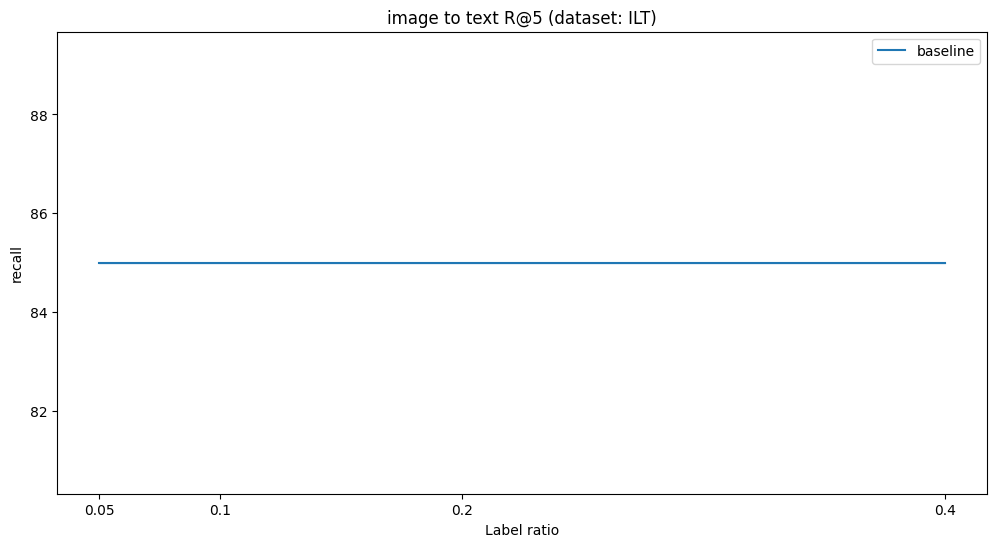

baseline text_to_image_R@5 ILT


lr epochs ratio AL.epochs method    PL  bs dataset AL.iter  \
                                                                      
5   0.00005     25  0.05      25.0   base  None  64     ILT     NaN   
12  0.00005     25  0.10      25.0   base  None  64     ILT     NaN   
19  0.00005     25  0.20      25.0   base  None  64     ILT     NaN   
26  0.00005     25  0.40      25.0   base  None  64     ILT     NaN   

               metric ProbVLM value             
                               mean  std count  
5   text_to_image_R@5   False  90.0  0.0     5  
12  text_to_image_R@5   False  90.0  0.0     5  
19  text_to_image_R@5   False  90.0  0.0     5  
26  text_to_image_R@5   False  90.0  0.0     5

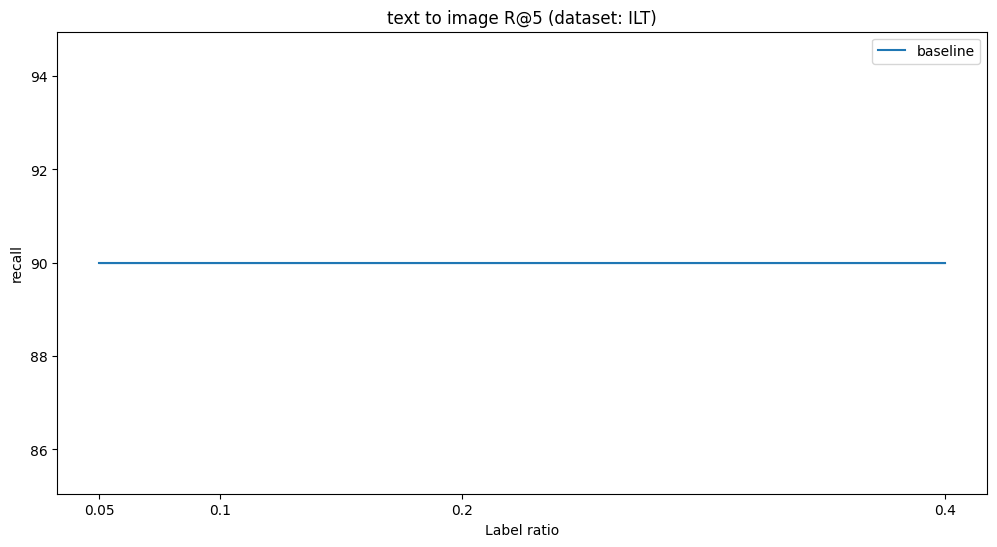

In [10]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['ILT']
for metric in metrics:
    for dataset in datasets:
        plot_model_comparison(results_dict, metric, dataset)

ILT-CLS zeroshot-val-top1
baseline zeroshot-val-top1 ILT-CLS


lr epochs ratio AL.epochs method    PL  bs  dataset AL.iter  \
                                                                       
6   0.00005     25  0.05      25.0   base  None  64  ILT-CLS     NaN   
13  0.00005     25  0.10      25.0   base  None  64  ILT-CLS     NaN   
20  0.00005     25  0.20      25.0   base  None  64  ILT-CLS     NaN   
27  0.00005     25  0.40      25.0   base  None  64  ILT-CLS     NaN   

               metric ProbVLM value             
                               mean  std count  
6   zeroshot-val-top1   False  40.0  0.0     5  
13  zeroshot-val-top1   False  40.0  0.0     5  
20  zeroshot-val-top1   False  40.0  0.0     5  
27  zeroshot-val-top1   False  40.0  0.0     5

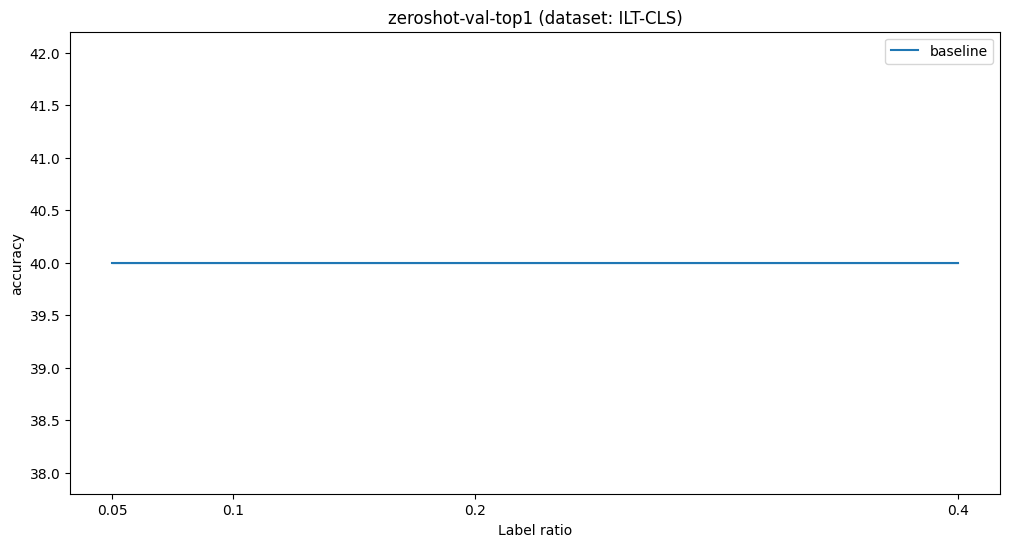

In [11]:
metric = 'zeroshot-val-top1'
datasets = ["ILT-CLS"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

baseline text_to_image_R@5 ILT


lr epochs ratio AL.epochs method    PL  bs dataset AL.iter  \
                                                                      
5   0.00005     25  0.05      25.0   base  None  64     ILT     NaN   
12  0.00005     25  0.10      25.0   base  None  64     ILT     NaN   
19  0.00005     25  0.20      25.0   base  None  64     ILT     NaN   
26  0.00005     25  0.40      25.0   base  None  64     ILT     NaN   

               metric ProbVLM value             
                               mean  std count  
5   text_to_image_R@5   False  90.0  0.0     5  
12  text_to_image_R@5   False  90.0  0.0     5  
19  text_to_image_R@5   False  90.0  0.0     5  
26  text_to_image_R@5   False  90.0  0.0     5

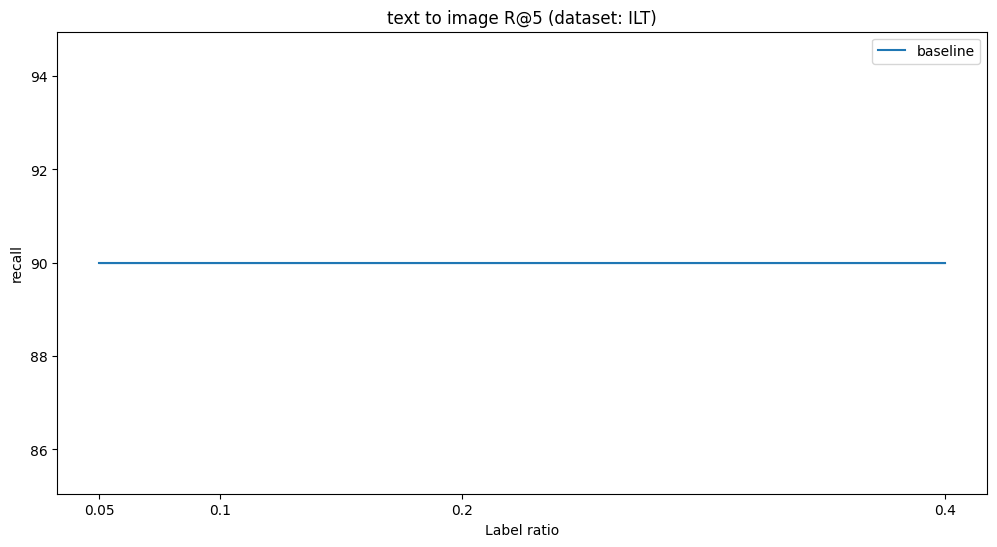

In [12]:
metric = 'text_to_image_R@5'
datasets = ['ILT']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)